# Face Recognition

import the libraries

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder

https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset/

Download dataset
and read it

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("data_1.zip", 'r')
zip_ref.extractall()
zip_ref.close()

[[ 35  57 160 160]]


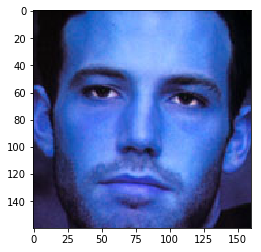

In [3]:
face_cascade = cv2.CascadeClassifier('haar.xml')
f = cv2.imread("data/train/ben_afflek/httpwwwallposterscomimagesPostersPFjpg.jpg")
faces = face_cascade.detectMultiScale(f,1.3,5)
print(faces)
for x,y,w,h in faces:
    plt.imshow(f[y:y+h, x:x+w])

Create dataset

In [4]:
face_cascade = cv2.CascadeClassifier('haar.xml')
dirs = "data/train/"
img_size = 60

data = []
for name in os.listdir(dirs):
    for f in os.listdir(dirs+name):
        f = cv2.imread(os.path.join(dirs+name, f))
        faces = face_cascade.detectMultiScale(f,1.3,5)
        for x,y,w,h in faces:
            img = f[y:y+h, x:x+w]
            img = cv2.resize(img, (img_size,img_size))
            data.append((img, name))
            
df = pd.DataFrame(data, columns=["image", "name"])
print("Length:",len(df))

Length: 99


Name:  elton_john


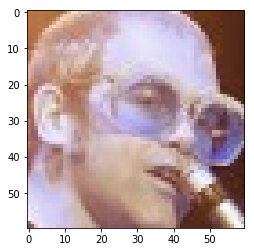

In [5]:
idx = 34
row = df.iloc[idx, :]
print("Name: ", row["name"])
plt.imshow(row.image)

create test data

In [6]:
dirs = "data/val/"

data = []
for name in os.listdir(dirs):
    for f in os.listdir(dirs+name):
        f = cv2.imread(os.path.join(dirs+name, f))
        faces = face_cascade.detectMultiScale(f,1.3,5)
        for x,y,w,h in faces:
            img = f[y:y+h, x:x+w]
            img = cv2.resize(img, (img_size,img_size))
            data.append((img, name))
            
df_test = pd.DataFrame(data, columns=["image", "name"])
print("Test size: ", len(df_test))

Test size:  24


## Preprocess data

In [7]:
le = LabelEncoder()
le.fit(df["name"].values)

LabelEncoder()

Training data

In [8]:
x_train = list(df.image.values)
x_train = np.array(x_train)
x_train = x_train/255
print(x_train.shape)

y_train = le.transform(df["name"].values)
print(y_train.shape)

(99, 60, 60, 3)
(99,)


Testing data

In [9]:
x_test = list(df_test.image.values)
x_test = np.array(x_test)
x_test = x_test/255
print(x_test.shape)

y_test = le.transform(df_test["name"].values)
print(y_test.shape)

(24, 60, 60, 3)
(24,)


## Prepare and Fit Models

In [10]:
people_num = len(np.unique(y_train))
people_num

5

#### Normal Model

In [0]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_size,img_size,3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(people_num, activation="softmax"))
    
    model.summary()
    return model

In [12]:
tf.reset_default_graph()
model = get_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

W0621 14:20:15.731552 139812032079744 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          4160      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [0]:
weight_dir = "weight_normal_model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [14]:
model.fit(x_train,y_train,validation_data=(x_test, y_test),epochs=50, batch_size=100, callbacks=[checkpoint])

Train on 99 samples, validate on 24 samples
Epoch 1/50
99/99 [==============================] - 1s 8ms/sample - loss: 1.6114 - acc: 0.1919 - val_loss: 1.6082 - val_acc: 0.2500
Epoch 2/50
99/99 [==============================] - 0s 5ms/sample - loss: 1.5901 - acc: 0.3333 - val_loss: 1.5978 - val_acc: 0.2500
Epoch 3/50
99/99 [==============================] - 0s 5ms/sample - loss: 1.5621 - acc: 0.2929 - val_loss: 1.5935 - val_acc: 0.2500
Epoch 4/50
99/99 [==============================] - 0s 5ms/sample - loss: 1.5273 - acc: 0.2929 - val_loss: 1.5736 - val_acc: 0.3750
Epoch 5/50
99/99 [==============================] - 0s 5ms/sample - loss: 1.4565 - acc: 0.4343 - val_loss: 1.5276 - val_acc: 0.3333
Epoch 6/50
99/99 [==============================] - 0s 5ms/sample - loss: 1.4608 - acc: 0.4040 - val_loss: 1.4415 - val_acc: 0.4167
Epoch 7/50
99/99 [==============================] - 0s 5ms/sample - loss: 1.3626 - acc: 0.5152 - val_loss: 1.3418 - val_acc: 0.4167
Epoch 8/50
99/99 [==============

#### Using Triplet Loss

In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:,:int(1/3*total_lenght)], y_pred[:,int(1/3*total_lenght):int(2/3*total_lenght)], y_pred[:,int(2/3*total_lenght):]
    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    return loss

In [0]:
def generate_triplets(x, y, num_same = 4, num_diff = 4):
    anchor_images = np.array([]).reshape((-1,)+ x.shape[1:])
    same_images = np.array([]).reshape((-1,)+ x.shape[1:])
    diff_images = np.array([]).reshape((-1,)+ x.shape[1:])
    
    for i in range(len(y)):
        point = y[i]        
        anchor = x[i]
        
        same_pairs = np.where(y == point)[0]
        same_pairs = np.delete(same_pairs , np.where(same_pairs == i))
        diff_pairs = np.where(y != point)[0]
               
        same = x[np.random.choice(same_pairs,num_same)]
        diff = x[np.random.choice(diff_pairs,num_diff)]
        
        anchor_images = np.concatenate((anchor_images, np.tile(anchor, (num_same * num_diff, 1, 1, 1) )), axis = 0)
                                       
        for s in same:
            same_images = np.concatenate((same_images, np.tile(s, (num_same, 1, 1, 1) )), axis = 0)
            
        diff_images = np.concatenate((diff_images, np.tile(diff, (num_diff, 1, 1, 1) )), axis = 0)
        
    return anchor_images, same_images, diff_images

In [17]:
anchor_images, same_images, diff_images = generate_triplets(x_train,y_train, num_same= 10, num_diff=10)
print(anchor_images.shape, same_images.shape, diff_images.shape)

(9900, 60, 60, 3) (9900, 60, 60, 3) (9900, 60, 60, 3)


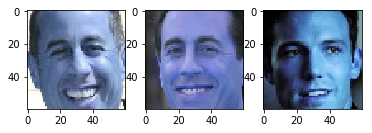

In [18]:
idx = 90
plt.subplot(1,3,1)
plt.imshow(anchor_images[idx])

plt.subplot(1,3,2)
plt.imshow(same_images[idx])

plt.subplot(1,3,3)
plt.imshow(diff_images[idx])

In [0]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_size,img_size,3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128))
              
    model.summary()
    return model

In [20]:
tf.reset_default_graph()
anchor_input = tf.keras.layers.Input((img_size, img_size, 3), name='anchor_input')
positive_input = tf.keras.layers.Input((img_size, img_size, 3), name='positive_input')
negative_input = tf.keras.layers.Input((img_size, img_size, 3), name='negative_input')

shared_dnn = get_model()

encoded_anchor = shared_dnn(anchor_input)
encoded_positive = shared_dnn(positive_input)
encoded_negative = shared_dnn(negative_input)

merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative],
                                            axis=-1, name='merged_layer')

model = tf.keras.Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.summary()
model.compile(loss=triplet_loss, optimizer="adam")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          4160      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [0]:
weight_dir = "weight_tripletloss_model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [22]:
Y_dummy = np.empty((anchor_images.shape[0],1))

model.fit([anchor_images,same_images,diff_images],y=Y_dummy, batch_size=128, epochs=100, callbacks=[checkpoint])

W0621 14:23:46.957695 139812032079744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
9900/9900 [==============================] - 117s 12ms/sample - loss: 7.7717
Epoch 2/100
9900/9900 [==============================] - 116s 12ms/sample - loss: 0.8572
Epoch 3/100
9900/9900 [==============================] - 115s 12ms/sample - loss: 0.4263
Epoch 4/100
9900/9900 [==============================] - 115s 12ms/sample - loss: 0.5120
Epoch 5/100
9900/9900 [==============================] - 115s 12ms/sample - loss: 0.3149
Epoch 6/100
9900/9900 [==============================] - 115s 12ms/sample - loss: 0.3481
Epoch 7/100
9900/9900 [==============================] - 115s 12ms/sample - loss: 0.2238
Epoch 8/100
9900/9900 [==============================] - 116s 12ms/sample - loss: 0.2383
Epoch 9/100
9900/9900 [==============================] - 115s 12ms/sample - loss: 0.1691
Epoch 10/100
9900/9900 [==============================] - 115s 12ms/sample - loss: 0.1306
Epoch 11/100
9900/9900 [==============================] - 115s 12ms/sample - loss: 0.5552
Epoch 12/100
9900/9

In [0]:
anchor_model = tf.keras.Model(inputs = anchor_input, outputs=encoded_anchor)

In [24]:
pred = anchor_model.predict(x_train)
pred.shape

(99, 128)

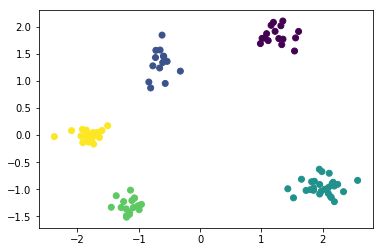

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)

In [0]:
def encode_image(model ,img):
    encode = model.predict(img.reshape((1,)+ img.shape))
    return encode

In [0]:
def dist_imgs(anchor_enc, img_enc):
    return np.linalg.norm(img_enc - anchor_enc)

In [0]:
name_dict = {}
for i in set(df["name"].values):
    img = df[df["name"] == i].iloc[0,0]/255
    enc = encode_image(anchor_model, img)
    name_dict[i] = enc

In [0]:
def predict_image(model, img, dictionary):
    enc = encode_image(model, img)
    max_dist = 10000000
    max_name = None
    for name in dictionary:
        dist = dist_imgs(dictionary[name], enc)
        print("Name: ", name, "Dist: ", dist)
        if max_dist > dist:
            max_dist = dist
            max_name = name
    
    return max_name, max_dist

Name:  mindy_kaling Dist:  4.0865316
Name:  jerry_seinfeld Dist:  0.4148198
Name:  elton_john Dist:  4.2889385
Name:  madonna Dist:  3.9979672
Name:  ben_afflek Dist:  3.2182763
Predicted name: jerry_seinfeld  with distance 0.4148198
Actual pred:  ['jerry_seinfeld']


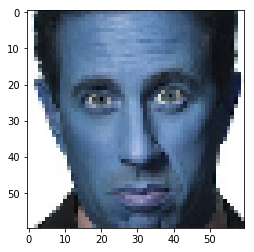

In [30]:
idx = 25
img = x_train[idx]
plt.imshow(img)

n, d = predict_image(anchor_model, img, name_dict)
print("Predicted name:",n ," with distance", d)
print("Actual pred: ", le.inverse_transform(y_train[idx:idx+1]))

Use K-means algo on encodings

In [0]:
pred_x_train = anchor_model.predict(x_train)

In [32]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(pred_x_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

Predicted name: ['ben_afflek']
Actual pred:  ['ben_afflek']


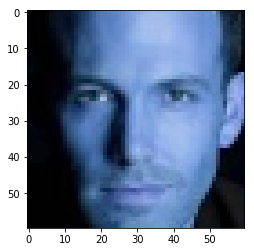

In [33]:
idx = 16
img = x_test[idx]
plt.imshow(img)

enc = encode_image(anchor_model, img)
pred = neigh.predict(enc)
print("Predicted name:",le.inverse_transform(pred))
print("Actual pred: ", le.inverse_transform(y_test[idx:idx+1]))

In [34]:
pred_x_test = anchor_model.predict(x_test)
pred = neigh.predict(pred_x_test)

print(np.sum(pred == y_test)/len(pred))


1.0
